In [108]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [2]:
curriculum_info=pd.read_json("curriculum-info.json")
chapter_info=pd.read_json("chapter-info.json")
lesson_info=pd.read_json("lesson-info.json")
unit_info=pd.read_json("unit-info.json")
unit_dependency=pd.read_json("unit-dependency.json")
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
curriculum_info

,id,name
0,13,Level C


In [4]:
train.head()

,id,user_id,unit_id,result,modified_at,type,is_step,problem_id,created_at
0,2173111,28878,10770,1,2018-05-31T21:56:14.000Z,LESSON,False,6092474,2018-05-31T21:55:58.000Z
1,2173115,28878,10770,1,2018-05-31T21:56:48.000Z,LESSON,False,6092476,2018-05-31T21:56:20.000Z
2,2173122,28878,10770,1,2018-05-31T21:57:23.000Z,LESSON,False,6092472,2018-05-31T21:56:57.000Z
3,2173150,28878,10771,1,2018-05-31T22:00:44.000Z,LESSON,False,6126355,2018-05-31T21:58:20.000Z
4,2173167,28878,10770,1,2018-05-31T22:00:44.000Z,LESSON,True,6126356,2018-05-31T21:59:08.000Z


In [5]:
train.isnull().sum()

id             0
user_id        0
unit_id        0
result         0
modified_at    0
type           0
is_step        0
problem_id     0
created_at     0
dtype: int64

# Feature Engineering

## unit dependencies count
관련된 유닛의 개수

In [6]:
dependent_count=unit_dependency.set_index("id")
dependent_count=dependent_count.loc[train["unit_id"]]["dependencies"].str.len()
dependent_count=dependent_count.reset_index(drop=True)
train["dependent_count"]=dependent_count

## time taken in sec
문제 푸는데 걸린 시간

In [7]:
train["modified_at"]=pd.to_datetime(train["modified_at"])
train["created_at"]=pd.to_datetime(train["created_at"])

In [8]:
time_taken=train["modified_at"]-train["created_at"]
time_taken=time_taken.astype(int)//(10**9)
train["time_taken"]=time_taken

## number of lessons
유닛이 속해있는 레슨 개수

In [9]:
lesson_count=unit_info.set_index("id")
lesson_count=pd.DataFrame(lesson_count.loc[train["unit_id"]])["lessons"].str.len()
lesson_count=lesson_count.reset_index(drop=True)
train["lesson_count"]=lesson_count

tried: Chapter seq, curriculum

## is_step bool to int

In [12]:
train["is_step"]=train["is_step"].astype(int)

## result should be 0,1

In [13]:
train=train[train["result"].isin([0,1])]
train.result.value_counts()

1    239761
0     49030
Name: result, dtype: int64

# split train/test

In [14]:
X=train[["type","is_step","dependent_count","time_taken","lesson_count"]]
X=pd.get_dummies(data=X,drop_first=True)
Y=train["result"]

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=99)

# Model

## check

In [15]:
model=sm.Logit(y_train,x_train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.452570
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 result   No. Observations:               202153
Model:                          Logit   Df Residuals:                   202147
Method:                           MLE   Df Model:                            5
Date:                Mon, 31 May 2021   Pseudo R-squ.:                0.008245
Time:                        14:21:26   Log-Likelihood:                -91488.
converged:                       True   LL-Null:                       -92249.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
is_step               -0.9039      0.016    -57.880      0.000      -0.934      -0.873
dependent_count        0.2761      0.004     73.147      0.000       0.269       0.284
time_taken            -0.0010   3.37e-05    -30.042      0.000      -0.001      -0.001
lesson_count           0.0245      0.000     68.196      0.000       0.024       0.025
type_LESSON            1.2149      0.010    126.649      0.000       1.196       1.234
type_PLACEMENTTEST    -0.4532      0.046     -9.835      0.000      -0.543      -0.363
======================================================================================
"""

## Model1: Logistic Regression

In [109]:
model1=LogisticRegression(solver='liblinear', C=100, random_state=99)
LogisticRegression?
model1.fit(x_train,y_train)
pred1=model1.predict(x_test)

In [17]:
print(classification_report(y_test,pred1))

              precision    recall  f1-score   support

           0       0.39      0.02      0.03     14607
           1       0.83      1.00      0.91     72031

    accuracy                           0.83     86638
   macro avg       0.61      0.51      0.47     86638
weighted avg       0.76      0.83      0.76     86638



In [18]:
confusion_matrix(y_test,pred1)

array([[  221, 14386],
       [  350, 71681]])

Text(33.0, 0.5, 'Actual')

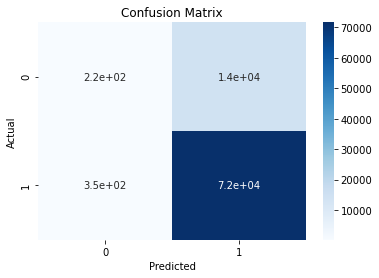

In [19]:
sn.heatmap(confusion_matrix(y_test,pred1),annot=True,cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Model2 : Balanced Logistic Regression

In [20]:
model2=LogisticRegression(C=5,random_state=99,class_weight="balanced")
model2.fit(x_train,y_train)
pred2=model2.predict(x_test)

In [21]:
print(classification_report(y_test,pred2))

              precision    recall  f1-score   support

           0       0.30      0.46      0.36     14607
           1       0.88      0.78      0.83     72031

    accuracy                           0.73     86638
   macro avg       0.59      0.62      0.59     86638
weighted avg       0.78      0.73      0.75     86638



In [22]:
model2.score(x_test, y_test)

0.7258593226990466

Text(33.0, 0.5, 'Actual')

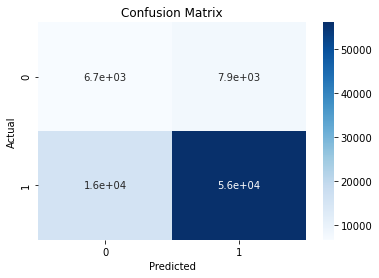

In [23]:
sn.heatmap(confusion_matrix(y_test,pred2),annot=True,cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Model3: SMOTE

<AxesSubplot:>

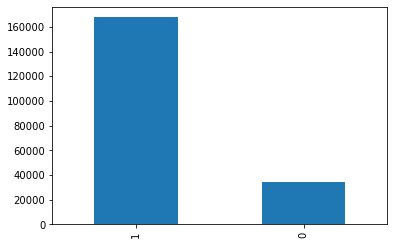

In [24]:
y_train.value_counts().plot(kind='bar')

In [25]:
smote=SMOTE(random_state=99)
x_train_smote,y_train_smote = smote.fit_resample(x_train,y_train)

<AxesSubplot:>

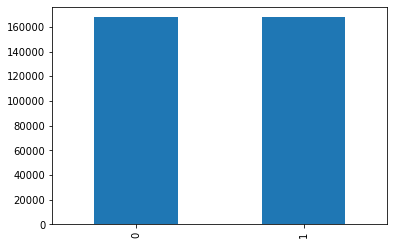

In [26]:
y_train_smote.value_counts().plot(kind='bar')

In [27]:
model3=LogisticRegression()
model3.fit(x_train_smote,y_train_smote)
pred3=model3.predict(x_test)

In [28]:
print(classification_report(y_test,pred3))

              precision    recall  f1-score   support

           0       0.27      0.61      0.37     14607
           1       0.89      0.67      0.76     72031

    accuracy                           0.66     86638
   macro avg       0.58      0.64      0.57     86638
weighted avg       0.79      0.66      0.70     86638



In [29]:
print(classification_report(y_test,pred1))

              precision    recall  f1-score   support

           0       0.39      0.02      0.03     14607
           1       0.83      1.00      0.91     72031

    accuracy                           0.83     86638
   macro avg       0.61      0.51      0.47     86638
weighted avg       0.76      0.83      0.76     86638



Text(33.0, 0.5, 'Actual')

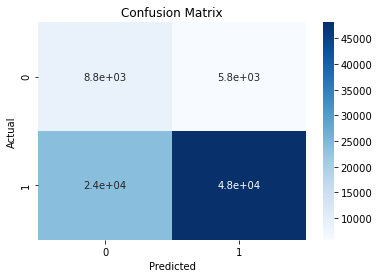

In [30]:
sn.heatmap(confusion_matrix(y_test,pred3),annot=True,cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Model4: Naive Bayes

In [31]:
model4 = GaussianNB()
model4.fit(x_train, y_train)
pred4=model4.predict(x_test)

In [32]:
print(classification_report(y_test,pred4))

              precision    recall  f1-score   support

           0       0.38      0.24      0.30     14607
           1       0.86      0.92      0.89     72031

    accuracy                           0.81     86638
   macro avg       0.62      0.58      0.59     86638
weighted avg       0.78      0.81      0.79     86638



Text(33.0, 0.5, 'Actual')

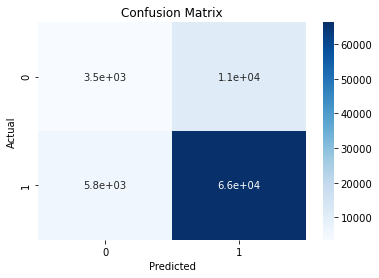

In [33]:
sn.heatmap(confusion_matrix(y_test,pred4),annot=True,cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Model5: Naive Bayes with SMOTE

In [34]:
model5 = GaussianNB()
model5.fit(x_train_smote, y_train_smote)
pred5=model5.predict(x_test)

In [35]:
print(classification_report(y_test,pred5))

              precision    recall  f1-score   support

           0       0.32      0.34      0.33     14607
           1       0.87      0.85      0.86     72031

    accuracy                           0.77     86638
   macro avg       0.59      0.60      0.60     86638
weighted avg       0.77      0.77      0.77     86638



Text(33.0, 0.5, 'Actual')

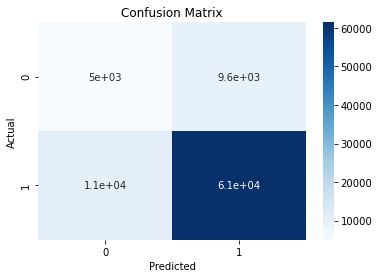

In [36]:
sn.heatmap(confusion_matrix(y_test,pred5),annot=True,cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Model6: SVM

>model6 = SVC(kernel='linear')<br>
model6.fit(x_train, y_train)<br>
pred6=model6.predict(x_test)

## Model7: Decision Tree

In [37]:
model7=DecisionTreeClassifier()
model7.fit(x_train,y_train)
pred7=model7.predict(x_test)

In [38]:
print(classification_report(y_test,pred7))

              precision    recall  f1-score   support

           0       0.39      0.22      0.28     14607
           1       0.85      0.93      0.89     72031

    accuracy                           0.81     86638
   macro avg       0.62      0.58      0.59     86638
weighted avg       0.78      0.81      0.79     86638



Text(33.0, 0.5, 'Actual')

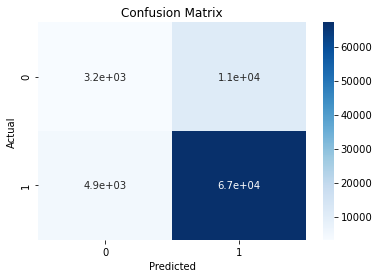

In [39]:
sn.heatmap(confusion_matrix(y_test,pred7),annot=True,cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Model8: KNN

In [40]:
model8=KNeighborsClassifier()
model8.fit(x_train,y_train)
pred8=model8.predict(x_test)

In [41]:
print(classification_report(y_test,pred8))

              precision    recall  f1-score   support

           0       0.40      0.17      0.24     14607
           1       0.85      0.95      0.90     72031

    accuracy                           0.82     86638
   macro avg       0.63      0.56      0.57     86638
weighted avg       0.77      0.82      0.79     86638



Text(33.0, 0.5, 'Actual')

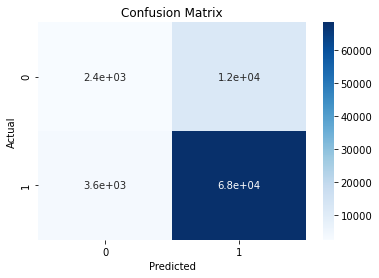

In [42]:
sn.heatmap(confusion_matrix(y_test,pred8),annot=True,cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Model9: RandomForest

In [43]:
model9=RandomForestClassifier(n_estimators=100)
model9.fit(x_train,y_train)
pred9=model9.predict(x_test)

In [44]:
print(classification_report(y_test,pred9))

              precision    recall  f1-score   support

           0       0.44      0.19      0.26     14607
           1       0.85      0.95      0.90     72031

    accuracy                           0.82     86638
   macro avg       0.65      0.57      0.58     86638
weighted avg       0.78      0.82      0.79     86638



Text(33.0, 0.5, 'Actual')

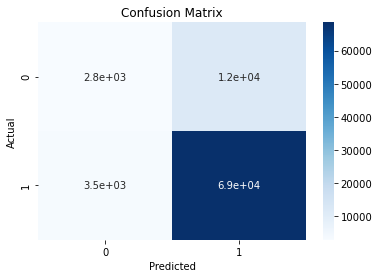

In [45]:
sn.heatmap(confusion_matrix(y_test,pred9),annot=True,cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Compare Models

In [46]:
accuracy=[model1.score(x_test, y_test),model2.score(x_test, y_test),model3.score(x_test, y_test),model4.score(x_test, y_test),model5.score(x_test, y_test),model7.score(x_test, y_test),model8.score(x_test, y_test),model9.score(x_test, y_test)]
f1_scores=[f1_score(y_test,pred1),f1_score(y_test,pred2),f1_score(y_test,pred3),f1_score(y_test,pred4),f1_score(y_test,pred5),f1_score(y_test,pred7),f1_score(y_test,pred8),f1_score(y_test,pred9)]
models=["model1","model2","model3","model4","model5","model7","model8","model9"]
compare=pd.DataFrame(list(zip(accuracy,f1_scores)),index=models,columns=['accuracy','f1_score'])
compare.sort_values(by=['accuracy'],ascending=False)

,accuracy,f1_score
model1,0.829913,0.906792
model9,0.823138,0.899477
model8,0.818036,0.896724
model7,0.811480,0.891520
model4,0.805374,0.887099
model5,0.767169,0.859000
model2,0.725859,0.825467
model3,0.657760,0.764564


# Cross Validation

In [66]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)

In [67]:
model1=LogisticRegression(solver='liblinear', C=100, random_state=99)
model2=LogisticRegression(C=5,random_state=99,class_weight="balanced")
model4=GaussianNB()
model7=DecisionTreeClassifier()
model8=KNeighborsClassifier()
model9=RandomForestClassifier(n_estimators=100)




In [68]:
score1 = cross_val_score(model1, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
score2 = cross_val_score(model2, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
score4 = cross_val_score(model4, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
score7 = cross_val_score(model7, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
score8 = cross_val_score(model8, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)
score9 = cross_val_score(model9, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)


In [71]:
models=["model1","model2","model4","model7","model8","model9"]
pd.DataFrame(list(zip(score1,score2,score4,score7,score8,score9)),columns=models).mean().sort_values(ascending=False)



model1    0.828850
model9    0.823190
model8    0.815802
model7    0.813161
model4    0.803611
model2    0.724853
dtype: float64

# Result : Choose Model 1 

In [72]:
test

,id,user_id,unit_id,result,modified_at,type,is_step,problem_id,created_at
0,5844437,64419,10485,NaN,2019-09-03T15:05:48.000Z,CHAPTERREVIEW,False,6779408,2019-09-03T15:05:15.000Z
1,5844438,64419,10377,NaN,2019-09-03T15:06:20.000Z,CHAPTERREVIEW,False,6775670,2019-09-03T15:05:56.000Z
2,5844440,64419,10488,NaN,2019-09-03T15:06:51.000Z,CHAPTERREVIEW,False,6779424,2019-09-03T15:06:28.000Z
3,5844443,64419,10429,NaN,2019-09-03T15:08:50.000Z,LESSON,False,6780710,2019-09-03T15:08:27.000Z
4,5844444,64419,10430,NaN,2019-09-03T15:09:50.000Z,LESSON,False,6780735,2019-09-03T15:08:59.000Z
...,...,...,...,...,...,...,...,...,...
26265,6572316,58146,11335,NaN,2019-12-28T19:45:29.000Z,LESSON,False,6831788,2019-12-28T19:37:28.000Z
26266,6572436,58146,11336,NaN,2019-12-28T19:46:27.000Z,LESSON,False,6833937,2019-12-28T19:46:16.000Z
26267,6572443,58146,11338,NaN,2019-12-28T19:54:13.000Z,LESSON,False,6831839,2019-12-28T19:46:34.000Z
26268,6572549,58146,11341,NaN,2019-12-28T20:08:57.000Z,LESSON,False,6842318,2019-12-28T19:54:32.000Z


In [73]:
dependent_count=unit_dependency.set_index("id")
dependent_count=dependent_count.loc[test["unit_id"]]["dependencies"].str.len()
dependent_count=dependent_count.reset_index(drop=True)
test["dependent_count"]=dependent_count

In [74]:
test["modified_at"]=pd.to_datetime(test["modified_at"])
test["created_at"]=pd.to_datetime(test["created_at"])

In [75]:
time_taken=test["modified_at"]-test["created_at"]
time_taken=time_taken.astype(int)//(10**9)
test["time_taken"]=time_taken

In [77]:
lesson_count=unit_info.set_index("id")
lesson_count=pd.DataFrame(lesson_count.loc[test["unit_id"]])["lessons"].str.len()
lesson_count=lesson_count.reset_index(drop=True)
test["lesson_count"]=lesson_count

In [78]:
test["is_step"]=test["is_step"].astype(int)

In [84]:
model1.fit(X,Y)

LogisticRegression(C=100, random_state=99, solver='liblinear')

In [85]:
test_X=test[["type","is_step","dependent_count","time_taken","lesson_count"]]
test_X=pd.get_dummies(data=test_X,drop_first=True)

In [99]:
out=pd.DataFrame(list(zip(test.id,model1.predict(test_X))),columns=["id","result"])

In [103]:
out.to_csv('submission.csv',index=False)